# Setup

## Import

In [1]:
from pyfk import SourceModel, SeisModel, Config
from dataclasses import dataclass
from typing import List
from obspy.geodetics import gps2dist_azimuth, locations2degrees
import matplotlib.pyplot as plt
from obspy import UTCDateTime
import numpy as np
import logging

print("PyFK and other classes imported successfully!")

PyFK and other classes imported successfully!


## Modify parameters

In [2]:
@dataclass
class SimulationConfig:
    """Configuration class for simulation parameters"""
    
    # MODIFY: Receiver index to analyze

    # MODIFY: Source parameters
    source_depths = [42, 98]
    receiver_distances = np.arange(400, 801, 400)
    azimuth = 45
    baz = (azimuth + 180) % 360
    
    # MODIFY: Source mechanism
    magnitude = 6
    strike = 90
    dip = 45
    rake = 90

    # MODIFY: GF, STF, synthetic plotting parameters
    npt = 2048 # for GFs
    dt = .1 # for GFs
    duration = 5 # for STF
    rise = 0.5 # for STF
    plot_freqmin = 0.02 # for synthetic plotting
    plot_freqmax = 0.5 # for synthetic plotting
    plot_corners = 4 # for synthetic plotting
    
    # MODIFY: Parameters for SnLg
    Sn_freqmin = .02
    Sn_freqmax = .5
    Lg_freqmin = .02
    Lg_freqmax = .5
    vsm=4.7
    vsc=3.7
    moho=[70.0]

    # Arbtirary parameters for SnLg
    sync_origintime = UTCDateTime('2021-04-28T02:21:26.196000Z')
    sync_longitude = -122.168861
    sync_latitude = 37.428230

    # Model parameters
    layer1_thickness = 3.0
    layer1_vs = 3.3
    layer1_vp = 5.8
    layer1_rho = 2.3
    layer1_q1 = 1000000
    layer1_q2 = 1000000
    
    layer2_thickness = 37.0
    layer2_vs = 3.5
    layer2_vp = 5.8
    layer2_rho = 2.8
    layer2_q1 = 1000000
    layer2_q2 = 1000000
    
    layer3_thickness = 30.0
    layer3_vs = 4.0
    layer3_vp = 6.9
    layer3_rho = 3.0
    layer3_q1 = 1000000
    layer3_q2 = 1000000
    
    layer4_thickness = 500.0
    layer4_vs = 4.9
    layer4_vp = 8.6
    layer4_rho = 3.3
    layer4_q1 = 1000000
    layer4_q2 = 1000000
    
    def get_mechanism(self) -> List[float]:
        return [self.magnitude, self.strike, self.dip, self.rake]

    def get_model_data(self):
        return np.array([
            [self.layer1_thickness, self.layer1_vs, self.layer1_vp, self.layer1_rho, self.layer1_q1, self.layer1_q2],  # 0-3 km
            [self.layer2_thickness, self.layer2_vs, self.layer2_vp, self.layer2_rho, self.layer2_q1, self.layer2_q2],  # 3-40 km  
            [self.layer3_thickness, self.layer3_vs, self.layer3_vp, self.layer3_rho, self.layer3_q1, self.layer3_q2],  # 40-70 km
            [self.layer4_thickness, self.layer4_vs, self.layer4_vp, self.layer4_rho, self.layer4_q1, self.layer4_q2],  # >70 km (to 500 km)
        ])

# Create configuration instance
parameters = SimulationConfig()
print("Config created successfully!")
print("Source depths: ", parameters.source_depths)
print("Receiver distances: ", parameters.receiver_distances)

Config created successfully!
Source depths:  [42, 98]
Receiver distances:  [400 800]


## Define models

In [3]:
# Create seismic model
model_data = parameters.get_model_data()
model = SeisModel(model=model_data)

# Create sources array
def setup_source(parameters, i):
    """Setup a source at a given depth (i)"""
    # Create source model
    source = SourceModel(
        sdep=parameters.source_depths[i],
        srcType="dc",
        source_mechanism=parameters.get_mechanism()
    )
    print(f"Source {i}:", source)
    return source
print("Creating sources array...")
sources = []
for i in range(len(parameters.source_depths)):
    source = setup_source(parameters, i)
    sources.append(source)

# Create configs array
def setup_config(model, source, parameters):
    """Setup configuration object for a given source; with error handling"""
    try:
        
        config_obj = Config(
            model=model,
            source=source,
            npt=parameters.npt,
            dt=parameters.dt,
            receiver_distance=np.array(parameters.receiver_distances)
        )
        print(f"Config {i}:", config_obj)
        return config_obj

    except Exception as e:
        logging.error(f"Error setting up configuration: {e}")
        raise
print("Creating configs array...")
configs = []
for i in range(len(sources)):
    config_obj= setup_config(model, sources[i], parameters)
    configs.append(config_obj)

Creating sources array...
Source 0: SourceModel(sdep=42, srcType=dc, source_mechanism=[ 6 90 45 90])
Source 1: SourceModel(sdep=98, srcType=dc, source_mechanism=[ 6 90 45 90])
Creating configs array...
Config 0: Config(model=SeisModel(layers=5, flattening=False), source=SourceModel(sdep=42, srcType=dc, source_mechanism=[ 6 90 45 90]), receiver_distance=[400. 800.], taper=0.3, filter=(0, 0), npt=2048, dt=0.1, dk=0.3, smth=1.0, pmin=0.0, pmax=1.0, kmax=15.0, rdep=0.0, updn=all, samples_before_first_arrival=50, suppression_sigma=2.0)
Config 1: Config(model=SeisModel(layers=5, flattening=False), source=SourceModel(sdep=98, srcType=dc, source_mechanism=[ 6 90 45 90]), receiver_distance=[400. 800.], taper=0.3, filter=(0, 0), npt=2048, dt=0.1, dk=0.3, smth=1.0, pmin=0.0, pmax=1.0, kmax=15.0, rdep=0.0, updn=all, samples_before_first_arrival=50, suppression_sigma=2.0)


# Calculate Green's functions

In [ ]:
# from pyfk import calculate_gf
# gfs = []

# for i in range(len(configs)):
#     config = configs[i]
#     gf = calculate_gf(config)
#     gfs.append(gf)
#     print('Calculated Green\'s function for source depth: ' + str(int(parameters.source_depths[i])).zfill(2) + 'km')

# print("----------------Structure of gfs----------------")
# print("gfs is an array; length equal to # of depths: \n", (gfs))
# print("gfs[0] are the streams for 1st depth; length equal to # of receivers: \n", gfs[0])
# print("gfs[0][0] is the stream for the 1st depth, 1st receiver; 9 traces in stream: \n", gfs[0][0])

Calculated Green's function for source depth: 42km
Calculated Green's function for source depth: 98km
----------------Structure of gfs----------------
gfs is an array; length equal to # of depths: 
 [[<obspy.core.stream.Stream object at 0x11fc1ccd0>, <obspy.core.stream.Stream object at 0x1273e5c70>], [<obspy.core.stream.Stream object at 0x127407b20>, <obspy.core.stream.Stream object at 0x1274078e0>]]
gfs[0] are the streams for 1st depth; length equal to # of receivers: 
 [<obspy.core.stream.Stream object at 0x11fc1ccd0>, <obspy.core.stream.Stream object at 0x1273e5c70>]
gfs[0][0] is the stream for the 1st depth, 1st receiver; 9 traces in stream: 
 9 Trace(s) in Stream:
... | 1970-01-01T00:00:51.620999Z - 1970-01-01T00:04:16.320999Z | 10.0 Hz, 2048 samples
... | 1970-01-01T00:00:51.620999Z - 1970-01-01T00:04:16.320999Z | 10.0 Hz, 2048 samples
... | 1970-01-01T00:00:51.620999Z - 1970-01-01T00:04:16.320999Z | 10.0 Hz, 2048 samples
... | 1970-01-01T00:00:51.620999Z - 1970-01-01T00:04:16.32

In [5]:
import os
from glob import glob
import obspy

def saveGF(path, gfs):
    """
    Save Green's functions to disk in SAC format.
    Each depth is saved in a separate folder.
    """
    if os.path.exists(path):
        os.system('rm -r ' + path)  # Remove existing directory if it exists
    os.mkdir(path)
    N = len(gfs) # Number of depths
    for i in range(N):
        os.mkdir(path + '/' + str(i).zfill(2))  # Create a folder for each depth
        gf_w = gfs[i] # Streams for given depth, one for each receiver distance
        for j in range(len(gf_w)): # Loop over stream for given depth and receiver distance
            gf_w[j].write(path + '/' + str(i).zfill(2) + "/grn_" + str(j).zfill(3) + "_.sac", format="SAC")

def readGF(path):
    """
    Read Green's functions from disk.
    Returns a nested list of obspy Stream objects.
    """
    GF = []
    dirs = glob(path + '/*')
    dirs.sort()
    for dir in dirs:
        GFn = []
        files = glob(dir + '/*_01.sac')
        files.sort()
        for file in files:
            # Read all matching SAC files for this Green's function
            stream = obspy.read(file[:-5] + '*')
            GFn.append(stream)
        GF.append(GFn)
    return GF

In [ ]:
# Folder Single_gfs, subfolder 01, file grn_001_06 indicates 2nd depth (01, 0 index), 2nd receiver (001, 0 index), 6th trace (06, 1 index)
# saveGF('Single_gfs', gfs)
gfs = readGF('Single_gfs')

print("----------------Structure of gfs----------------")
print("gfs is an array; length equal to # of depths: \n", (gfs))
print("gfs[0] are the streams for 1st depth; length equal to # of receivers: \n", gfs[0])
print("gfs[0][0] is the stream for the 1st depth, 1st receiver; 9 traces in stream: \n", gfs[0][0])

----------------Structure of gfs----------------
gfs is an array; length equal to # of depths: 
 [[<obspy.core.stream.Stream object at 0x12755fdc0>, <obspy.core.stream.Stream object at 0x107e79d00>], [<obspy.core.stream.Stream object at 0x12745ff40>, <obspy.core.stream.Stream object at 0x12748a6a0>]]
gfs[0] are the streams for 1st depth; length equal to # of receivers: 
 [<obspy.core.stream.Stream object at 0x12755fdc0>, <obspy.core.stream.Stream object at 0x107e79d00>]
gfs[0][0] is the stream for the 1st depth, 1st receiver; 9 traces in stream: 
 9 Trace(s) in Stream:
... | 1970-01-01T00:00:51.620998Z - 1970-01-01T00:04:16.320998Z | 10.0 Hz, 2048 samples
... | 1970-01-01T00:00:51.620998Z - 1970-01-01T00:04:16.320998Z | 10.0 Hz, 2048 samples
... | 1970-01-01T00:00:51.620998Z - 1970-01-01T00:04:16.320998Z | 10.0 Hz, 2048 samples
... | 1970-01-01T00:00:51.620998Z - 1970-01-01T00:04:16.320998Z | 10.0 Hz, 2048 samples
... | 1970-01-01T00:00:51.620998Z - 1970-01-01T00:04:16.320998Z | 10.0 H

# Generate STF

In [7]:
dura = parameters.duration
rise = parameters.rise
delta = parameters.dt

# # ------ Triangular
# from pyfk import generate_source_time_function  # Import source time function generator
# source_time_function = generate_source_time_function(dura=dura, rise=rise, delta=delta)
# print("Source time function generated.")

# ------ Ricker wavelet
from obspy import Trace
def generate_source_time_function2(
        dura: float = 1.0,
        rise: float = 1.0,  # Increase rise time to lower dominant frequency
        delta: float = 0.1) -> Trace:
    """
    Generate a Ricker wavelet source time function with smooth frequency spectrum
    """
    ns = int(dura / delta)
    if ns < 2:
        ns = 2
    
    # Create time array
    t = np.arange(0, dura + delta, delta)
    center = dura / 2
    
    # Use rise time to determine dominant frequency
    # Longer rise time = lower frequency
    dominant_freq = 1.0 / (3.0 * rise)  # Reduced from 2.0 to 3.0
    
    # Generate Ricker wavelet
    arg = np.pi * dominant_freq * (t - center)
    result_data = (1 - 2 * arg**2) * np.exp(-arg**2)
    
    # Normalize
    result_data = result_data / np.max(np.abs(result_data))
    
    result_trace = Trace(header={}, data=result_data)
    result_trace.stats.delta = delta
    return result_trace
source_time_function = generate_source_time_function2(dura=dura, rise=rise, delta=delta)
print("Source time function generated.")

Source time function generated.


## Plot STF with filter band

Frequencies above 10% max: 0.20 to 1.37 Hz


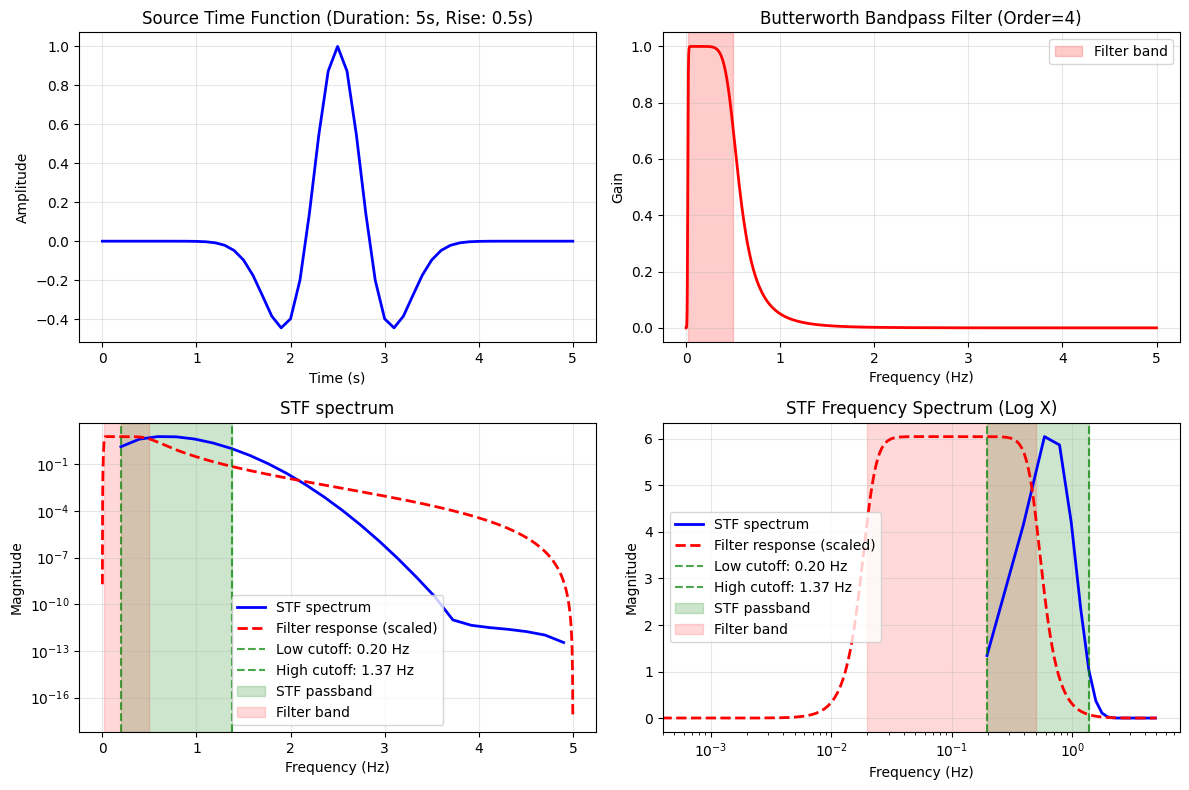

STF duration: 5 seconds
STF passband: 0.20-1.37 Hz
Filter band: 0.02-0.5 Hz


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# Calculate frequency spectrum
n = len(source_time_function)  # Get the number of points in the STF
freq = fftfreq(n, delta)       # Create frequency axis from -Nyquist to +Nyquist (Hz)
fft_stf = fft(source_time_function)  # Convert STF from time domain to frequency domain
magnitude = np.abs(fft_stf)    # Get the amplitude (magnitude) at each frequency

# Frequency domain: get positive frequencies and their magnitudes
positive_freq_mask = freq > 0  # Create mask for positive frequencies only
freq_pos = freq[positive_freq_mask]
mag_pos = magnitude[positive_freq_mask]

# ------Find cutoff frequencies
max_amp = np.max(mag_pos)
threshold = 0.1 * max_amp

# Find all indices where magnitude is above threshold
above_10_mask = mag_pos >= threshold
if np.any(above_10_mask):
    # Get all frequencies above threshold
    freqs_above = freq_pos[above_10_mask]
    print(f"Frequencies above 10% max: {freqs_above[0]:.2f} to {freqs_above[-1]:.2f} Hz")
    # Set low and high cutoff
    low_cutoff_freq = freqs_above[0]
    high_cutoff_freq = freqs_above[-1]
else:
    print("WARNING: No frequencies above 10% of max amplitude.")
    low_cutoff_freq = None
    high_cutoff_freq = None

# ------Plot filter, STF and frequency spectrum for both
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
ax1 = axes[0, 0]  # Top left
ax2 = axes[0, 1]  # Top right
ax3 = axes[1, 0]  # Bottom left
ax4 = axes[1, 1]  # Bottom right

# ---Time domain
time_stf = np.arange(len(source_time_function)) * delta  # Create time axis (seconds)
ax1.plot(time_stf, source_time_function, 'b-', linewidth=2)  # Plot STF in time domain
ax1.set_title(f'Source Time Function (Duration: {dura}s, Rise: {rise}s)')  # Set title with parameters
ax1.set_xlabel('Time (s)')     # Label x-axis
ax1.set_ylabel('Amplitude')    # Label y-axis
ax1.grid(True, alpha=0.3)      # Add grid with transparency

# ---Filter parameters (from parameters)
from scipy.signal import butter, freqz
# Filter parameters
freqmin = parameters.plot_freqmin
freqmax = parameters.plot_freqmax
corners = 4
fs = 1.0 / parameters.dt  # Sampling frequency
# Design Butterworth bandpass filter
nyq = 0.5 * fs  # Calculate the Nyquist frequency (half the sampling rate)
low = freqmin / nyq  # Normalize the lower cutoff frequency (as a fraction of Nyquist)
high = freqmax / nyq  # Normalize the upper cutoff frequency (as a fraction of Nyquist)
b, a = butter(corners, [low, high], btype='band')  
# Design a Butterworth bandpass filter of order 'corners' with normalized cutoff frequencies.
# 'b' and 'a' are the filter coefficients for the numerator and denominator, respectively.
w, h = freqz(b, a, worN=8000)  
# Compute the frequency response of the filter.
# 'w' is an array of frequencies (in radians/sample), 'h' is the complex frequency response.
f = w * fs / (2 * np.pi)  
# Convert the frequency array 'w' from radians/sample to Hz for plotting.
# Plotting
ax2.plot(f, abs(h), 'r', linewidth=2)
ax2.set_title(f'Butterworth Bandpass Filter (Order={corners})')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Gain')
ax2.grid(True, alpha=0.3)
ax2.axvspan(freqmin, freqmax, color='red', alpha=0.2, label='Filter band')
ax2.legend()

# ---Frequency domain (log y-axis)
ax3.semilogy(freq_pos, mag_pos, 'b-', linewidth=2, label='STF spectrum')
ax3.plot(f, abs(h) * np.max(mag_pos), 'r--', linewidth=2, label='Filter response (scaled)')
ax3.axvline(x=low_cutoff_freq, color='green', linestyle='--', alpha=0.7, label=f'Low cutoff: {low_cutoff_freq:.2f} Hz')
ax3.axvline(x=high_cutoff_freq, color='green', linestyle='--', alpha=0.7, label=f'High cutoff: {high_cutoff_freq:.2f} Hz')
ax3.axvspan(low_cutoff_freq, high_cutoff_freq, color='green', alpha=0.2, label='STF passband')
ax3.axvspan(freqmin, freqmax, color='red', alpha=0.15, label='Filter band')
ax3.set_title('STF spectrum')
ax3.set_xlabel('Frequency (Hz)')
ax3.set_ylabel('Magnitude')
ax3.grid(True, alpha=0.3)
ax3.legend()


# ---Frequency domain (log x-axis)
ax4.semilogx(freq_pos, mag_pos, 'b-', linewidth=2, label='STF spectrum')
ax4.plot(f, abs(h) * np.max(mag_pos), 'r--', linewidth=2, label='Filter response (scaled)')
ax4.axvline(x=low_cutoff_freq, color='green', linestyle='--', alpha=0.7, label=f'Low cutoff: {low_cutoff_freq:.2f} Hz')
ax4.axvline(x=high_cutoff_freq, color='green', linestyle='--', alpha=0.7, label=f'High cutoff: {high_cutoff_freq:.2f} Hz')
ax4.axvspan(low_cutoff_freq, high_cutoff_freq, color='green', alpha=0.2, label='STF passband')
ax4.axvspan(freqmin, freqmax, color='red', alpha=0.15, label='Filter band')
ax4.set_title('STF Frequency Spectrum (Log X)')
ax4.set_xlabel('Frequency (Hz)')
ax4.set_ylabel('Magnitude')
ax4.grid(True, alpha=0.3)
ax4.legend()

plt.tight_layout()
plt.show()

print(f"STF duration: {dura} seconds")
print(f"STF passband: {low_cutoff_freq:.2f}-{high_cutoff_freq:.2f} Hz")
print(f"Filter band: {freqmin}-{freqmax} Hz")

# Calculate synthetics

In [9]:
from pyfk import calculate_sync

sync_results = []
for i in range(len(gfs)): # loop over depths
    sync_result = calculate_sync(gfs[i], configs[i], parameters.azimuth, source_time_function) # calculate sync for given depth, all receivers
    sync_results.append(sync_result)
    print(f"Calculated synthetic seismograms for depth {i}: {sync_result}")

print("----------------Structure of sync_results----------------")
print("sync_results is an array; length equal to # of depths: \n", sync_results)
print("sync_results[0] are the streams for 1st depth; length equal to # of receivers: \n", sync_results[0])
print("sync_results[0][0] is the stream for the 1st depth, 1st receiver; 3 traces (Z, R, T) in stream: \n", sync_results[0][0]) 

for i in range(len(sync_results)):
    for j in range(len(sync_results[i])):
        selected_sync = sync_results[i][j] # stream for given depth (i) and receiver distance (j)
        # Assign channel codes to synthetic traces (Z, R, T components)
        channel_codes = ['BHZ', 'BHR', 'BHT'] 
        for k, tr in enumerate(selected_sync):
            tr.stats.channel = channel_codes[k]
        # Set synthetic trace to start at correct time (accounting for shift)
        for tr in selected_sync:
            tr.stats.starttime = parameters.sync_origintime + tr.stats.sac.b
            tr.stats.sac.o = -tr.stats.sac.b

Calculated synthetic seismograms for depth 0: [<obspy.core.stream.Stream object at 0x127574e20>, <obspy.core.stream.Stream object at 0x1275b0730>]
Calculated synthetic seismograms for depth 1: [<obspy.core.stream.Stream object at 0x14750a730>, <obspy.core.stream.Stream object at 0x147257850>]
----------------Structure of sync_results----------------
sync_results is an array; length equal to # of depths: 
 [[<obspy.core.stream.Stream object at 0x127574e20>, <obspy.core.stream.Stream object at 0x1275b0730>], [<obspy.core.stream.Stream object at 0x14750a730>, <obspy.core.stream.Stream object at 0x147257850>]]
sync_results[0] are the streams for 1st depth; length equal to # of receivers: 
 [<obspy.core.stream.Stream object at 0x127574e20>, <obspy.core.stream.Stream object at 0x1275b0730>]
sync_results[0][0] is the stream for the 1st depth, 1st receiver; 3 traces (Z, R, T) in stream: 
 3 Trace(s) in Stream:
... | 1970-01-01T00:00:51.620998Z - 1970-01-01T00:04:16.320998Z | 10.0 Hz, 2048 samp

<!-- # Implement TauP model (already created in FK_Compare) -->

# Plot synthetics for shallow and deep source, selected receiver

In [10]:
def process_component(component, parameters):
    """Process a single component with standard filtering"""
    processed_component = component.copy()
    processed_component.detrend("linear")
    processed_component.taper(max_percentage=0.05, type='hann')
    processed_component.filter("bandpass", freqmin=parameters.plot_freqmin, freqmax=parameters.plot_freqmax, 
                         corners=parameters.plot_corners, zerophase=True)
    return processed_component

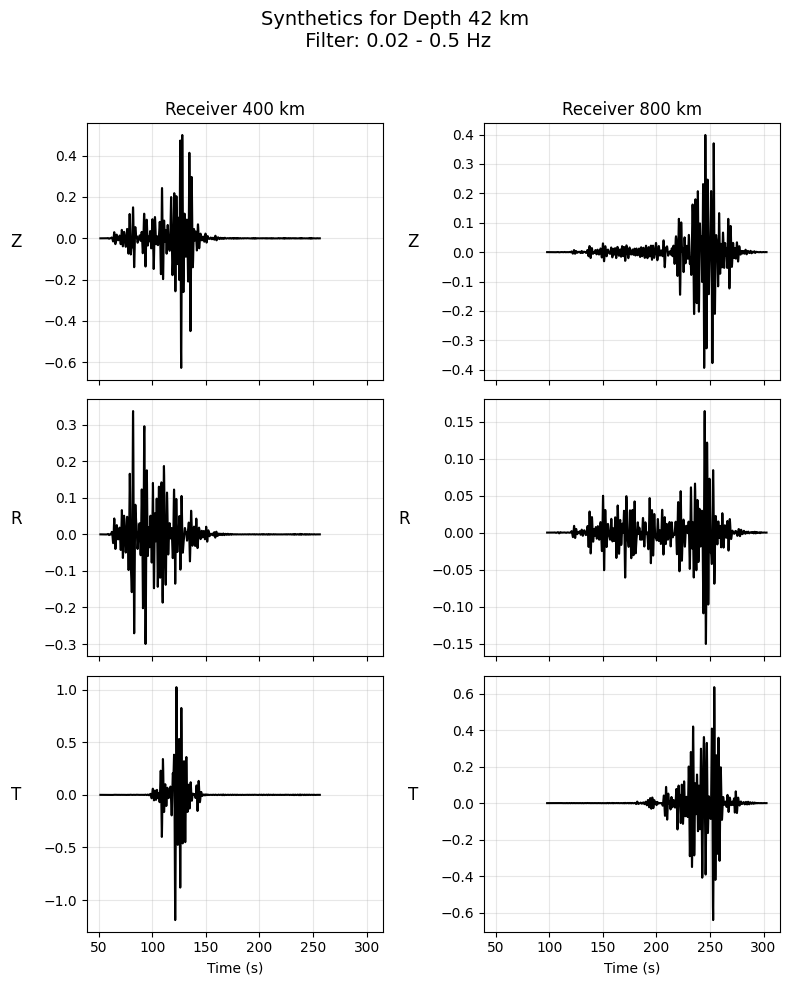

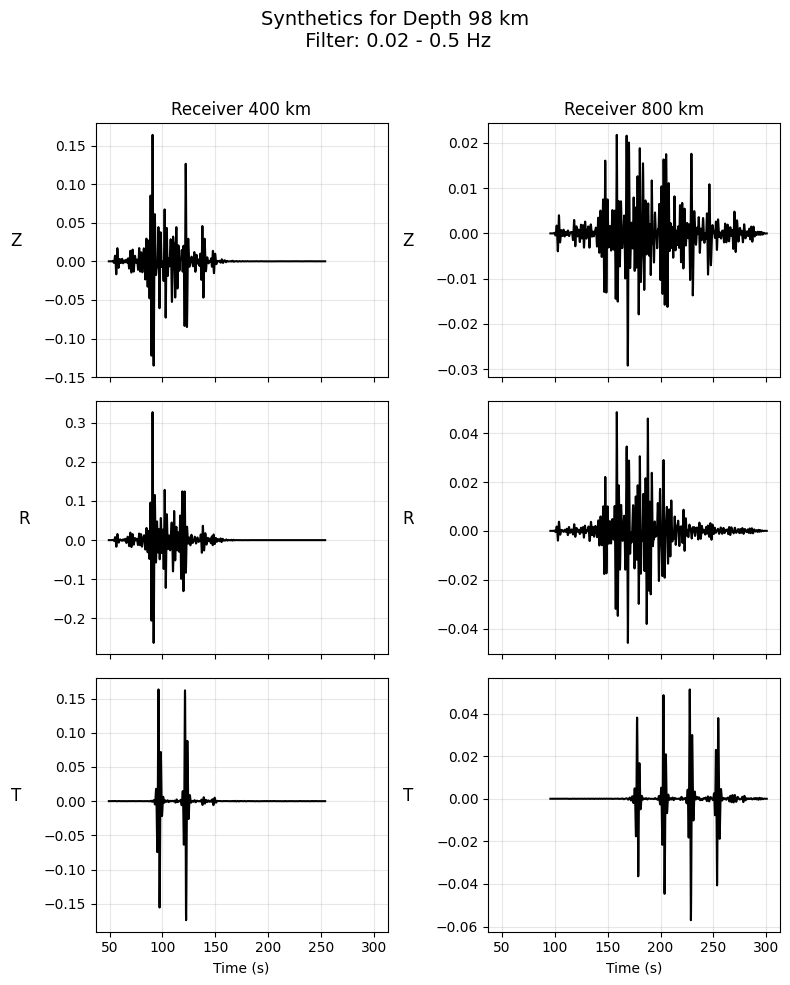

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# --- User settings ---
component_names = ['Z', 'R', 'T']

# --- Plot each depth separately with actual amplitudes ---
n_receivers = len(parameters.receiver_distances)
n_depths = len(parameters.source_depths)

for depth_idx in range(n_depths):
    fig, axes = plt.subplots(3, n_receivers, figsize=(4*n_receivers, 10), sharex=True)
    if n_receivers == 1:
        axes = axes.reshape(-1, 1)
    
    fig.suptitle(f"Synthetics for Depth {parameters.source_depths[depth_idx]:.0f} km\n Filter: {parameters.plot_freqmin} - {parameters.plot_freqmax} Hz", fontsize=14)
    
    for receiver_idx in range(n_receivers):
        for comp_idx, comp in enumerate(component_names):
            ax = axes[comp_idx, receiver_idx]
            
            # Get stream for this depth and receiver
            stream = sync_results[depth_idx][receiver_idx]
            
            # Process component
            tr = process_component(stream[comp_idx], parameters)
            t = np.arange(tr.stats.npts) * tr.stats.delta + tr.stats.sac.b
            
            # Plot with actual amplitudes (no normalization)
            ax.plot(t, tr.data, color='k', linewidth=1.5)
            
            # Set labels
            ax.set_ylabel(f"{comp}", rotation=0, labelpad=20, fontsize=12)
            if comp_idx == 0:
                ax.set_title(f"Receiver {parameters.receiver_distances[receiver_idx]:.0f} km")
            if comp_idx == 2:
                ax.set_xlabel("Time (s)")
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()